# Supplementary code

# Comparison of the Di Genova (2017) and Le Losq (2012) methods for using Raman spectra to quantify water content of glasses.

Di Genova et al. (2017) recently proposed a reassessment of existing ways to quantify
water content of glasses with using Raman spectroscopy. Those authors payed a
particular attention to the effects of iron content, oxidation state and
nanolites presence in volcanic glasses on the quantification of water from their
Raman spectra. They investigated the use of internal calibrations for
quantifying water content in glasses. Those calibrations are based on the
correlation between the ratio of the areas of water and silicate peaks, $R_{ws}$, and the water content of glass
standards, which can be expressed as (Le Losq et al. 2012):

$$\frac{wt\% H_2O}{wt\% H_2O - wt\% glass} = A * HW/LW = A * R_{ws} , (eq. 1) $$

with A a calibration coefficient, HW the integrated intensity measured between
3100 and 3750 cm$^{-1}$ and LW the integrated intensity measured at
frequencies lower than 1500 cm$^{-1}$.

To define the spectral background, Le Losq et al. (2012) proposed a protocol that uses cubic spline functions to fit the basis of the peaks assigned to vibrations in the aluminosilicate network (Figure 1). They further defined LW as equal to the integrated intensity of all the signals assigned to aluminosilicate
vibrations, typically observed between ~ 50 and ~ 1500 cm$^{-1}$. The
glasses investigated by Le Losq et al. (2012) cover a broad chemical range, from iron-free
albite to iron-bearing andesite and dacite, including other glasses with compositions such as
rhyolites, tonalites, haplogranites, and basalts. Le Losq et al. (2012) showed that the
adopted protocol allowed them to obtain a calibration independent on the sample
chemistry.

Di Genova et al. (2017) revise the methodology of internal
calibration by analysing iron-bearing hydrous natural glasses. They
first tested the method of Le Losq et al. (2012), and reported a slight dependence of the
*A* coefficient in eq. 1 to the glass iron content and iron redox. They
then adopted a slightly different protocol to fit the spectral background, based on the use of a
3$^{rd}$ order polynomial function. Di Genova et al. (2017) related the glass water content and the measured
$R_{ws}$ ratios through the equation:

$$wt\% H_2O = K * HW/LW = K * R_{ws} , (eq. 2) $$

with

$$K = a*[FeO] + b , (eq. 3) $$

where a and b are parameters ajusted by fitting the correlation between $wt\% H_2O$ and $R_{ws}$, and [FeO] is the glass total iron content expressed as wt% FeO.

This present notebook allows performing those calculations and comparing both methods. It uses a Python Class *rameau* in which all treatments are performed and all variables stored. As such, it provides an easy way to apply both methods, which present different advantages and robustness. The *rameau* class is part of the *rampy* library.

Spectra published by Le Losq et al. (2012), available as supplementary materials in Le Losq et al. (2012) or on Zenodo (https://zenodo.org/record/1183413#.WqCoVpNuYsk), are used. Those spectra are representative of glasses with compositions ranging from basalts to rhyolites, with iron contents
from 0 to 8.5 wt% and water contents from ~ 0 to ~ 12 wt%. This dataset is called the *2012* dataset.

A new dataset of Raman spectra acquired at
the Research School of Earth Sciences was further investigated. It contains 56 spectra from (i) 11 hydrous mid-ocean ridge and back-arc basalts from Sinton et al. (2003) and Shaw et al. (2004) that present water contents ranging between ~ 0.2 and ~ 1.9 wt% water, and (ii) 5 hydrous iron-free Ca aluminosilicate glasses from Le Losq et al. (2017).

# First step: dependencies & library call

Python version: notebook tested on Python 2.7 and 3.6

Dependencies: the dependencies are very common, at the exception of rampy that can be installed through pip. 
The dependencies list is:
    - numpy
    - scipy
    - matplotlib
    - pandas
    - gcvspline (install it in a console with 'pip install gcvspline', requires a running FORTRAN compiler).
    - rampy (install it in a console with 'pip install rampy')
    
Remark: plots use a LaTex fontend, so if you don't have one, it will probably fail. In this case, comment the lines 31 and 34 of the following cell or install LaTex.

In the later cell, a function for plotting each spectra is also provided. See the function documentation for details.

## See the examples in the rampy repository on Github for further details on the use of Rampy. 

Address is https://github.com/charlesll/rampy

Please consult regularly the rampy Github, as this package is under active development.

## If needing help for a particular function/class, just type help(my_function) in python to print the function/class help

In [1]:
########## Calling relevant libraries ##########
%matplotlib inline
import numpy as np
import scipy.optimize as op
from sklearn.metrics import mean_squared_error
import scipy

# Setting matplotlib options for this notebook
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 3.25, 6.5
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 6
plt.rcParams['legend.fontsize'] = 12

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams['text.latex.preamble'] = r'\usepackage{subdepth}, \usepackage{type1cm}'

import pandas as pd
#import gcvspline
import rampy as rp

# Import of the datasets

Datasets are available at:

- For the LL2012 dataset, see DOI: 10.5281/zenodo.1183413

- For the RSES 2018 dataset, see https://doi.pangaea.de/10.1594/PANGAEA.887209

An Excel file containing the information about the data can be used, see the provided spreadsheet as an example. The file dataset.xlsx contains two tabs with information for both datasets: 2012_AmMin and 2018_RSES.

In [2]:
# Data treatment
data_liste=pd.read_excel("dataset.xlsx",sheet_name="2012_AmMin")
data_liste_rses = pd.read_excel("dataset.xlsx",sheet_name="2018_RSES")

# Treatment of the datasets

Treatment is done using the rampy.rameau() method. This method allows to perform both treatments on stored objects (i.e. the spectra and all variables are stored inside a Python object).

Four steps are necessary: object creation, data reduction (spectra processing), calibration and prediction.
With a list of spectra data_liste, those steps are easily done as follow (with rampy imported as rp):

- creation of the object:
    - `object_created = rp.rameau(data_liste)`
- data processing:
    - `object_created.data_reduction()` [this calls the data_reduction function associated with the object)]
- calibration:
    - `object_created.calibrate(method="LL2012" or "DG2017")`
- prediction: 
    - `object_created.predict(method="LL2012" or "DG2017")`
    
Each functions has many other possibilities, see their help by typing, for instance, `help(rp.rameau.data_reduction)`

After the object creation and all data processing steps, the object contains all results, which can be called as, for instance for Rws, `object_created.rws`.

*Remark: to make prediction without calibration, one would set the parameters of the LL2012 or DG2017 methods as*

`object_created.p = np.array([A])` for LL2012

*or*

`object_created.p = np.array([a,b])` for DG2017

and then directly call `object_created.predict` without a prior call of `object_created.calibrate`.

In [3]:
#
# treatment of the 2012 dataset with both methods
# 
print("")
print("Treating the dataset from Le Losq et al. 2012")
print("")
# ll_2012 and df_2012 are two objects with associated function. see documentation

ll_2012 = rp.rameau(data_liste)
ll_2012.data_reduction(method="LL2012",laser=514.532)
ll_2012.calibrate(method="LL2012")
ll_2012.predict(method="LL2012")

dg_2012 = rp.rameau(data_liste)
dg_2012.data_reduction(method="DG2017",laser=514.532)
dg_2012.calibrate(method="DG2017")
dg_2012.predict(method="DG2017")

#
# treatment of the 2018 dataset with both methods
#
print("")
print("Treating the dataset from RSES, 2018")
print("")
ll_2018 = rp.rameau(data_liste_rses)
ll_2018.data_reduction(method="LL2012",laser=532.0,spline_coeff=0.0005)
ll_2018.calibrate(method="LL2012")
ll_2018.predict(method="LL2012")

dg_2018 = rp.rameau(data_liste_rses)
dg_2018.data_reduction(method="DG2017",laser=532.0)
dg_2018.calibrate(method="DG2017")
dg_2018.predict(method="DG2017")


Treating the dataset from Le Losq et al. 2012

Using adjusted A coefficient: 0.008165
Using adjusted p coefficients: 0.103871 and 0.858306

Treating the dataset from RSES, 2018

Using adjusted A coefficient: 0.009296
Using adjusted p coefficients: -0.003261 and 1.322256


# Code for the Figures

## Figure 1

Illustrate the difference in baseline treatment between the methods of DG2017 and LL 2012.

We see that the method of LL2012 fit the basis of the peaks between 0 and 1250 cm$^{-1}$, while the third-order polynomial of DG2017 does not.

At high frequency, both treatment are similar. The method of LL2012 seems to allow smoother variations of the background due to the use of a smoothing spline.

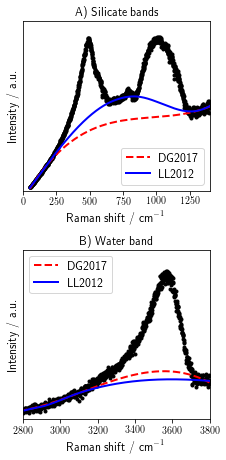

In [4]:
# Figure 1
s_sp = 41 # Spectra from a dacite, see file liste

plt.figure(figsize=(3.25, 6.5))

#
# Subplot A
# 

ax1 = plt.subplot(2,1,1)
ax1.plot(ll_2012.x,ll_2012.y[:,s_sp],'k.')
ax1.plot(dg_2012.x,dg_2012.y_base[:,s_sp],'r--',label='DG2017')
ax1.plot(ll_2012.x,ll_2012.y_base[:,s_sp],'b-',label='LL2012')

ax1.set_title("A) Silicate bands")

ax1.set_xlabel("Raman shift / cm$^{-1}$")
ax1.set_ylabel("Intensity / a.u.")
ax1.set_xlim(0,1400)
plt.ylim(0,np.max(ll_2012.y[ll_2012.x<1500,s_sp])+0.1*np.max(ll_2012.y[ll_2012.x<1500,s_sp]))
ax1.set_yticks([])
ax1.legend()

#
# Subplot B
# 

ax2 = plt.subplot(2,1,2)
ax2.plot(ll_2012.x,ll_2012.y[:,s_sp],'k.')
ax2.plot(dg_2012.x,dg_2012.y_base[:,s_sp],'r--',label='DG2017')
ax2.plot(ll_2012.x,ll_2012.y_base[:,s_sp],'b-',label='LL2012')

ax2.set_title("B) Water band")

ax2.set_xlabel("Raman shift / cm$^{-1}$")
ax2.set_ylabel("Intensity / a.u.")
ax2.set_xlim(2800,3800)
ax2.set_ylim(np.min(ll_2012.y[ll_2012.x>2500,s_sp])-0.1*np.min(ll_2012.y[ll_2012.x>2500,s_sp]),np.max(ll_2012.y[ll_2012.x>2500,s_sp])+0.1*np.max(ll_2012.y[ll_2012.x>2500,s_sp]))
ax2.set_yticks([])
ax2.legend()

plt.tight_layout()

plt.savefig("./Figure1.pdf")

## Figure 2

Comparison of the known water content of the glass standards from @LeLosq2012 with the Raman calculated values following the A) LL2012 and B) DG2017 protocols.

Dataset 2012 Am. Min
Standard deviation with the method of LL 2012 is :0.31
Standard deviation with the method of DG 2017 is :0.47


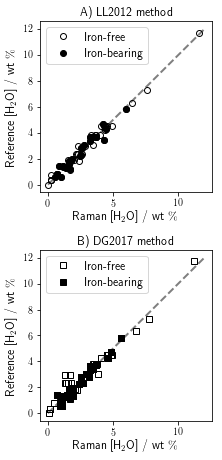

In [5]:
# Figure 2

RMSE_spline = np.sqrt(mean_squared_error(ll_2012.water_predicted, ll_2012.water))
RMSE_poly = np.sqrt(mean_squared_error(dg_2012.water_predicted, dg_2012.water))

print('Dataset 2012 Am. Min')
print('Standard deviation with the method of LL 2012 is :'+str(np.round(RMSE_spline,2)))
print('Standard deviation with the method of DG 2017 is :'+str(np.round(RMSE_poly,2)))

plt.figure(figsize=(3.25, 6.5))

#
# Subplot A
# 

plt.subplot(2,1,1)

plt.plot(ll_2012.water_predicted,data_liste["Water, wt%"],"o",mfc="none",mec="k",label="Iron-free")
plt.plot(ll_2012.water_predicted[np.where(data_liste["FeO"]>0)],data_liste["Water, wt%"].loc[data_liste["FeO"]>0],"o",mfc="k",mec="k",label="Iron-bearing")

plt.plot([0,12],[0,12],"k--",alpha=0.5)
plt.xlabel(r"Raman [H$_2$O] / wt $\%$")
plt.ylabel(r"Reference [H$_2$O] / wt $\%$")
plt.title("A) LL2012 method")
plt.legend()

#
# Subplot B
# 

plt.subplot(2,1,2)
plt.plot(dg_2012.water_predicted,data_liste["Water, wt%"],"s",mfc="none",mec="k",label="Iron-free")
plt.plot(dg_2012.water_predicted[np.where(data_liste["FeO"]>0)],data_liste["Water, wt%"].loc[data_liste["FeO"]>0],"s",mfc="k",mec="k",label="Iron-bearing")

plt.plot([0,12],[0,12],"k--",alpha=0.5)

plt.xlabel(r"Raman [H$_2$O] / wt $\%$")
plt.ylabel(r"Reference [H$_2$O] / wt $\%$")
plt.title("B) DG2017 method")
plt.legend()

plt.tight_layout()

plt.savefig("./Figure2.pdf")

## Figure 3

Comparison of the known water content of basalts and Ca aluminosilicate glass standards with the Raman calculated values following the A) LL2012 and B) DG2017 protocols.

Dataset 2018 RSES
Standard deviation with the method of LL 2012 is :0.31
Standard deviation with the method of DG 2017 is :0.24


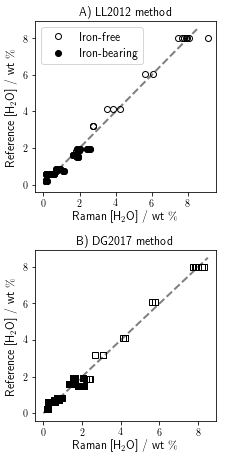

In [6]:
# Figure 3
RMSE_spline_rses = np.sqrt(mean_squared_error(ll_2018.water_predicted, ll_2018.water))
RMSE_poly_rses = np.sqrt(mean_squared_error(dg_2018.water_predicted, dg_2018.water))

print('Dataset 2018 RSES')
print('Standard deviation with the method of LL 2012 is :'+str(np.round(RMSE_spline_rses,2)))
print('Standard deviation with the method of DG 2017 is :'+str(np.round(RMSE_poly_rses,2)))

plt.figure(figsize=(3.25, 6.5))
plt.subplot(2,1,1)

plt.plot(ll_2018.water_predicted,ll_2018.water,"o",mfc="none",mec="k",label="Iron-free")
plt.plot(ll_2018.water_predicted[np.where(data_liste_rses["FeO"]>0)],data_liste_rses["Water, wt%"].loc[data_liste_rses["FeO"]>0],"o",mfc="k",mec="k",label="Iron-bearing")

plt.plot([0,8.5],[0,8.5],"k--",alpha=0.5)
plt.xlabel(r"Raman [H$_2$O] / wt $\%$")
plt.ylabel(r"Reference [H$_2$O] / wt $\%$")
plt.title("A) LL2012 method")
plt.legend()

plt.subplot(2,1,2)
plt.plot(dg_2018.water_predicted,data_liste_rses["Water, wt%"],"s",mfc="none",mec="k",label="Iron-free")
plt.plot(dg_2018.water_predicted[np.where(data_liste_rses["FeO"]>0)],data_liste_rses["Water, wt%"].loc[data_liste_rses["FeO"]>0],"s",mfc="k",mec="k",label="Iron-bearing")

plt.plot([0,8.5],[0,8.5],"k--",alpha=0.5)

plt.xlabel(r"Raman [H$_2$O] / wt $\%$")
plt.ylabel(r"Reference [H$_2$O] / wt $\%$")
plt.title("B) DG2017 method")

plt.tight_layout()

plt.savefig("./Figure3.pdf")

# Additional function for plotting all the spectra

The function below allows to plot the spectra, and eventually to export them in indicated folders.

To plot one spectra (this does not save anything), call `plot_spectra(rameau_object,idx=i)` with indice the number of the spectra you want (warning, Python is 0-based, so the first spectra is at idx=0)

To plot all spectra, just ommit to indicate idx but indicate the path: `plot_spectra(rameau_object,path_out="the_path_you_want")`

## Function definition

In [7]:
# Function definitions
def plot_spectra(rameau_object,**kwargs):

    idx = kwargs.get("idx",False)
    path_out = kwargs.get("path_out",[])
    
    if idx is not False:
        plt.figure(figsize=(6.5,3.25))
        ax1 = plt.subplot(1,2,1)
        ax1.plot(rameau_object.x,rameau_object.y[:,idx],'k.',ms=0.5)
        ax1.plot(rameau_object.x,rameau_object.y_base[:,idx],'r-')
        ax1.set_xlim(0,1500)
        ax1.set_ylim(0,np.max(rameau_object.y[np.where(rameau_object.x<1500),idx])+0.1*np.max(rameau_object.y[np.where(rameau_object.x<1500),idx]))

        ax1.set_xlabel(r'Raman shift, cm$^{-1}$')
        ax1.set_ylabel(r'Intensity, a. u.')

        ax2 = plt.subplot(1,2,2)
        ax2.plot(rameau_object.x,rameau_object.y[:,idx],'k.',ms=0.5)
        ax2.plot(rameau_object.x,rameau_object.y_base[:,idx],'r-')
        ax2.set_xlim(2700,4000)
        ax2.set_ylim(0,np.max(rameau_object.y[np.where(rameau_object.x>2700),idx])+0.1*np.max(rameau_object.y[np.where(rameau_object.x<4000),idx]))

        ax2.set_xlabel(r'Raman shift, cm$^{-1}$')
        ax2.set_ylabel(r'Intensity, a. u.')

        plt.tight_layout()
        
    else:
        print("Save spectra in provided path: %s"%path_out)
        for i in range(rameau_object.y.shape[1]):
            plt.figure(figsize=(6.5,3.25))
            ax1 = plt.subplot(1,2,1)
            ax1.plot(rameau_object.x,rameau_object.y[:,i],'k.',ms=0.5)
            ax1.plot(rameau_object.x,rameau_object.y_base[:,i],'r-')
            ax1.set_xlim(0,1500)
            ax1.set_ylim(0,np.max(rameau_object.y[np.where(rameau_object.x<1500),i])+0.1*np.max(rameau_object.y[np.where(rameau_object.x<1500),i]))

            ax1.set_xlabel(r'Raman shift, cm$^{-1}$')
            ax1.set_ylabel(r'Intensity, a. u.')

            ax2 = plt.subplot(1,2,2)
            ax2.plot(rameau_object.x,rameau_object.y[:,i],'k.',ms=0.5)
            ax2.plot(rameau_object.x,rameau_object.y_base[:,i],'r-')
            ax2.set_xlim(2700,4000)
            ax2.set_ylim(0,np.max(rameau_object.y[np.where(rameau_object.x>2700),i])+0.1*np.max(rameau_object.y[np.where(rameau_object.x<4000),i]))

            ax2.set_xlabel(r'Raman shift, cm$^{-1}$')
            ax2.set_ylabel(r'Intensity, a. u.')

            plt.tight_layout()
            plt.savefig(path_out+rameau_object.names[i]+".pdf")
            plt.close()
        

# Example of plotting one spectra

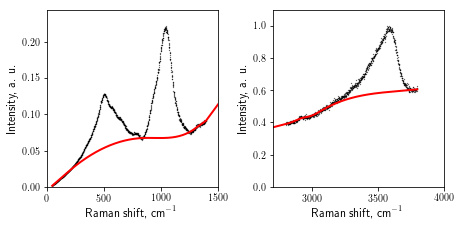

In [8]:
plot_spectra(ll_2018,idx=1)

# Plotting all spectra with the lines below, outputs in given folders (should exist prior to run)

This can take time...

In [9]:
%%time
plot_spectra(ll_2012,path_out="./figures/2012_dataset/LL2012/")
plot_spectra(dg_2012,path_out="./figures/2012_dataset/DG2017/")

plot_spectra(ll_2018,path_out="./figures/2018_dataset/LL2012/")
plot_spectra(dg_2018,path_out="./figures/2018_dataset/DG2017/")

Save spectra in provided path: ./figures/2012_dataset/LL2012/
Save spectra in provided path: ./figures/2012_dataset/DG2017/
Save spectra in provided path: ./figures/2018_dataset/LL2012/
Save spectra in provided path: ./figures/2018_dataset/DG2017/
CPU times: user 2min 15s, sys: 10.8 s, total: 2min 26s
Wall time: 5min 59s


# Final: printing help of Rameau for example

In [10]:
help(rp.rameau)

Help on class rameau in module rampy.rameau:

class rameau(builtins.object)
 |  treat Raman spectra of glass to retrieve the glass water content
 |  
 |  Parameters
 |  ==========
 |  data_liste: Pandas dataframe
 |      A Pandas dataframe containing the data and various meta information.
 |  
 |  Attributes
 |  ==========
 |  x: ndarray
 |      a 1D array (Nx1) containing the common x axis (wavelength) of the spectra.
 |  y: ndarray
 |      a NxM array (with M the number of spectra) containing the raw intensities of the spectra.
 |  y_corr: ndarray
 |      a NxM array (with M the number of spectra) containing the corrected intensities of the spectra.
 |  y_base: ndarray
 |      a NxM array (with M the number of spectra) containing the backgrounds of the spectra.
 |  rws: ndarray
 |      a 1D array (Nx1) containing the ratio between the integrated intensities of the water and silicate signals.
 |  rw: ndarray
 |      a 1D array (Nx1) containing the integrated intensities of the water s